## Part 1: 
Load data, clean, and save aggregate data

In [1]:
import pandas as pd 
import os
import numpy as np
from data_cleaning import change_columns_types
from data_loading import aggregate_data
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#immport necessary libraries and filter warnings
import warnings


from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer
from utility_db_25 import mark_columns, TrainML, build_catboost, optuna_call, test_ML, build_transformer, get_momentum_cols, create_momentum_index, get_final_features, get_motion_cols, motion_complexity_score
from team_logos import graph_run_pass, get_logo_df, load_previous_year_passruns
warnings.filterwarnings("ignore")

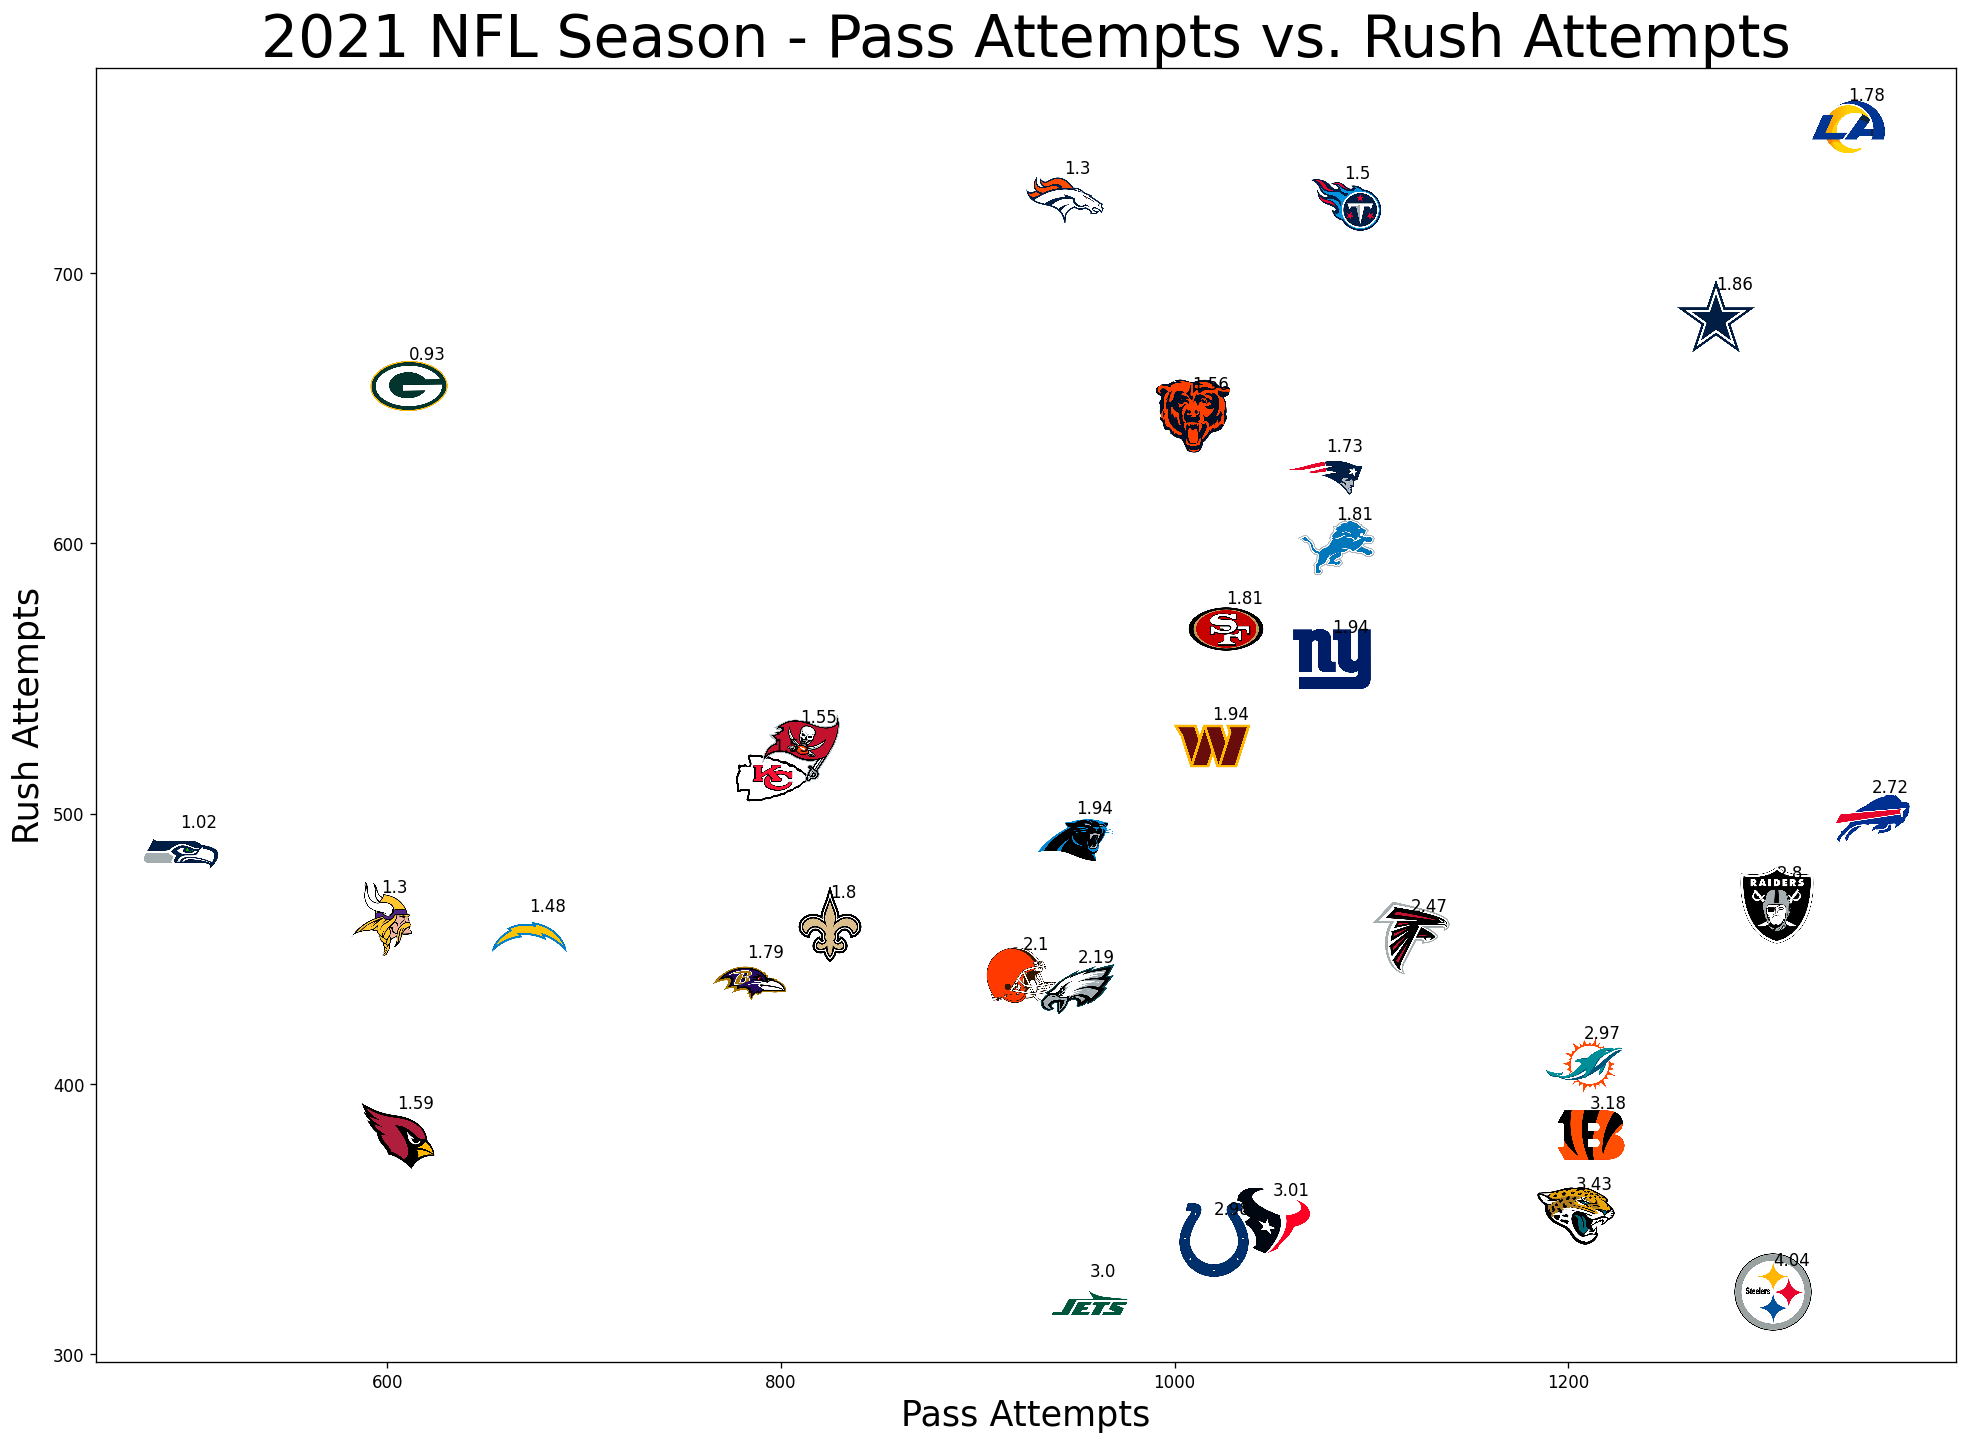

In [2]:
graph_run_pass()

In [3]:
root_dir = os.getcwd()

load_saved_data = True     # if you change this to true you can load presaved data

if not load_saved_data: 
    games_fname= os.path.join(root_dir, "data/games.csv")
    plays_fname = os.path.join(root_dir,  "data/plays.csv")
    players_fname = os.path.join(root_dir,  "data/players.csv")
    player_plays_fname = os.path.join(root_dir,  "data/player_play.csv")
    c21_fname = os.path.join(root_dir, 'data_21/cov_21.csv')
    pr21_fname = os.path.join(root_dir, 'data_21/team_pr_21.csv')
    xp_fname = os.path.join(root_dir, "data/team_xpass_ratios.csv")
    pr_fname = os.path.join(root_dir, "data/team_pass_rates.csv")
    cf_fname = os.path.join(root_dir, "data/coverages_faced.csv")
    cu_fname = os.path.join(root_dir, 'data/coverages_used.csv')
    inj_fname = os.path.join(root_dir, 'data/snaps_lost_injury.csv')
    tracking_fname_list_train = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,9)] #weeks 1-8 are training data
    tracking_fname_list_test = [os.path.join(root_dir,  "data/tracking_week_9.csv")] #week 9 is test data
    train_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_train, games_fname, xp_fname, pr_fname, cu_fname,inj_fname, c21_fname, pr21_fname,'train')
    train_data.to_csv(os.path.join(root_dir, "data/train_data.csv"), index=False)
    test_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_test, games_fname, xp_fname, pr_fname, cu_fname,inj_fname, c21_fname, pr21_fname,'test')
    test_data.to_csv(os.path.join(root_dir, "data/test_data.csv"), index=False)
else:
    train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
    test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
print('train colums: ', len(train_data.columns))
print('test colums: ', len(test_data.columns))

train colums:  431
test colums:  361


In [4]:
include_columns=test_data.columns
train_data=train_data[include_columns]


In [5]:

momentum_cols=get_momentum_cols(train_data.columns)

train_data=create_momentum_index(train_data, momentum_cols)
test_data=create_momentum_index(test_data, momentum_cols)
motion_cols=get_motion_cols(train_data.columns)
train_data=motion_complexity_score(train_data, motion_cols)
test_data=motion_complexity_score(test_data, motion_cols)




## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment.

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [6]:

for col in train_data.columns: 
    if round((train_data[col].isna().sum() /len(train_data)*100), 2)>75:
        train_data.drop(columns=col, inplace=True)
    elif round((train_data[col].isna().sum() /len(train_data)*100), 2)>0:
        print(col,round((train_data[col].isna().sum() /len(train_data)*100), 2), '% missing')
    else: 
        print(col)

gameId
playId
quarter
down
yardsToGo
score_differential
time_remaining 0.81 % missing
playNullifiedByPenalty
preSnapHomeTeamWinProbability
pass_rush_ratio 2.84 % missing
Rain
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing
preSnapVisitorTeamWinProbability
absoluteYardlineNumber
pass
s|max|C_1
s|max|C_2
s|max|FB_1
s|max|G_1
s|max|G_2
s|max|G_3
s|max|ILB_1
s|max|QB_1
s|max|QB_2
s|max|RB_1
s|max|RB_2
s|max|TE_1
s|max|TE_2
s|max|TE_3
s|max|T_1
s|max|T_2
s|max|T_3
s|max|T_4
s|max|WR_1
s|max|WR_2
s|max|WR_3
s|max|WR_4
s|max|WR_5
a|max|C_1
a|max|C_2
a|max|FB_1
a|max|G_1
a|max|G_2
a|max|G_3
a|max|ILB_1
a|max|QB_1
a|max|QB_2
a|max|RB_1
a|max|RB_2
a|max|TE_1
a|max|TE_2
a|max|TE_3
a|max|T_1
a|max|T_2
a|max|T_3
a|max|T_4
a|max|WR_1
a|max|WR_2
a|max|WR_3
a|max|WR_4
a|max|WR_5
o_standard|mean|C_1
o_standard|mean|C_2
o_standard|mean|FB_1
o_standard|mean|G_1
o_standard|mean|G_2
o_standard|mean|G_3
o_standard|mean|ILB_1
o_standard|mean|QB_1
o_standard|mean|QB_2
o_standard|mean|RB_1
o_st

In [7]:
len(train_data.columns)

317

In [8]:
train_data=change_columns_types(train_data)
test_data=change_columns_types(test_data)

In [9]:
final_features=get_final_features(train_data,threshold=.5,trim_rows=0)

In [10]:
numeric_columns, cat_columns = mark_columns(df=train_data,features=final_features, nc=None,cc = None)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

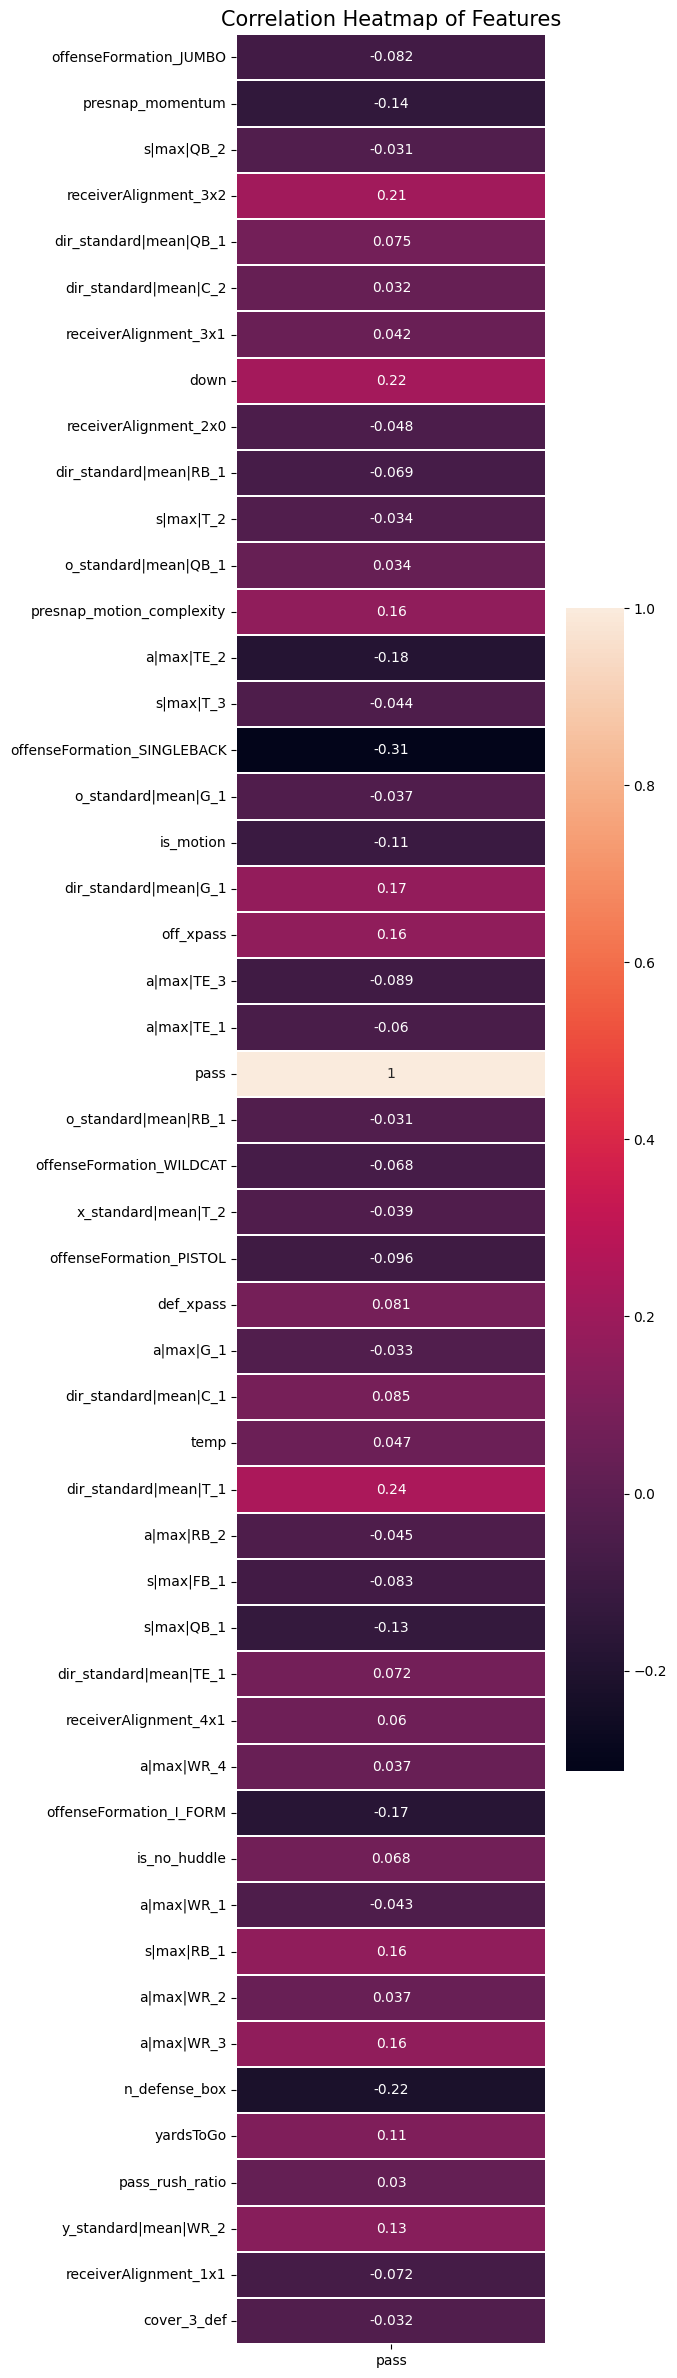

In [11]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,30))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(train_data[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [12]:
# Create an imputer object with mean strategy
#imputer = SimpleImputer(strategy='mean')
from sklearn.compose import ColumnTransformer

# Fit and transform the data
#merged_pivot[numeric_columns] = imputer.fit_transform(merged_pivot[numeric_columns])
imputer = SimpleImputer(missing_values = np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns),('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [13]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=train_data[final_features].drop(columns='pass')

y=train_data['pass']

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]

Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


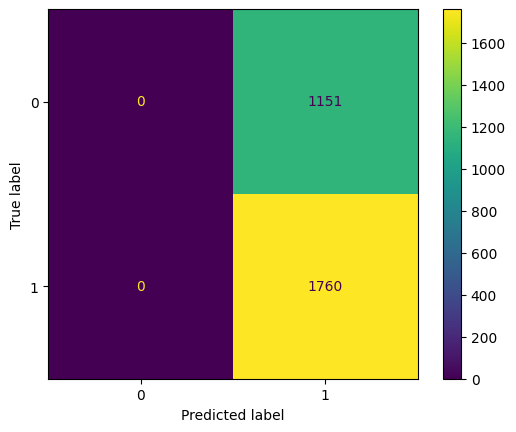

In [14]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y, n_splits,SEED)

Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

Mean Train AUC --> 0.8781
Mean Validation AUC ---> 0.7823
Mean Train Accuracy --> 0.8850
Mean Validation Accuracy ---> 0.7940


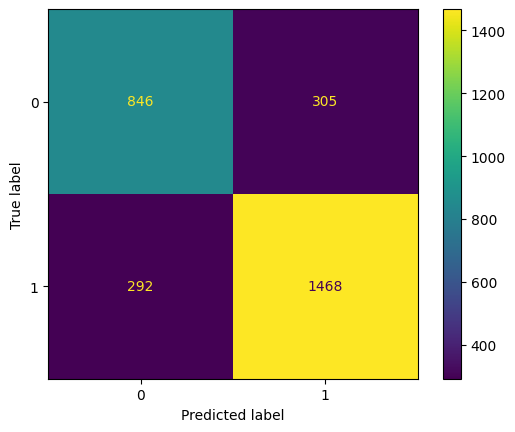

In [15]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
TrainML(pipeline,X, y,n_splits,SEED)

Training Folds: 100%|██████████| 5/5 [00:40<00:00,  8.17s/it]

Mean Train AUC --> 0.8876
Mean Validation AUC ---> 0.7833
Mean Train Accuracy --> 0.8959
Mean Validation Accuracy ---> 0.7971


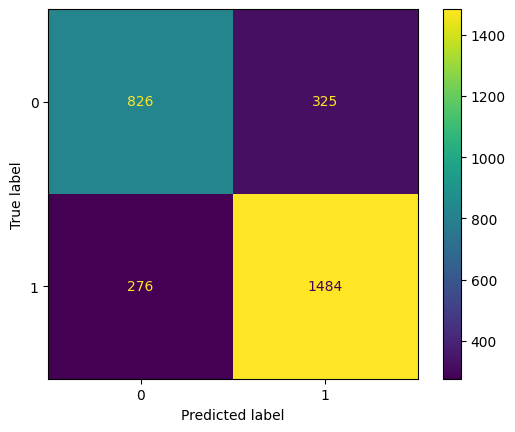

In [16]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  verbose=False))], verbose = True)
TrainML(pipeline,X, y,n_splits,SEED)

In [17]:
final_features.remove('pass')

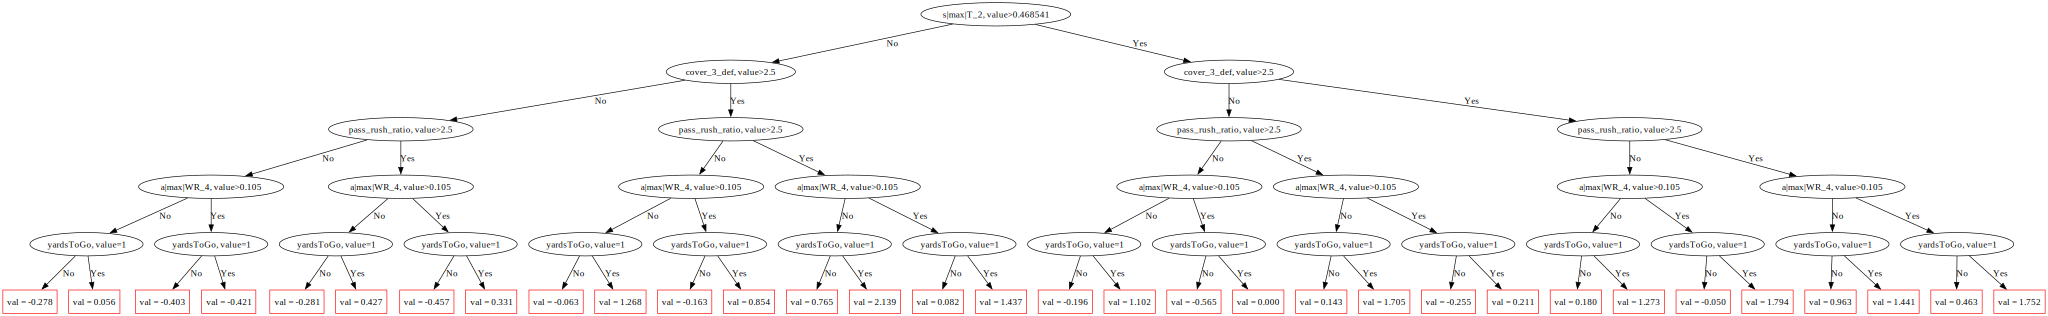

In [18]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline
#need graphviz for this part and to add to path https://graphviz.org/download/

# For explicitly displaying widgets
from IPython.display import display

model, pool, cat_features_index, X_transform = build_catboost(final_features, train_data, imputer, {'max_depth':5,'iterations':2})


model.plot_tree(
    tree_idx=1,
    pool=pool
)

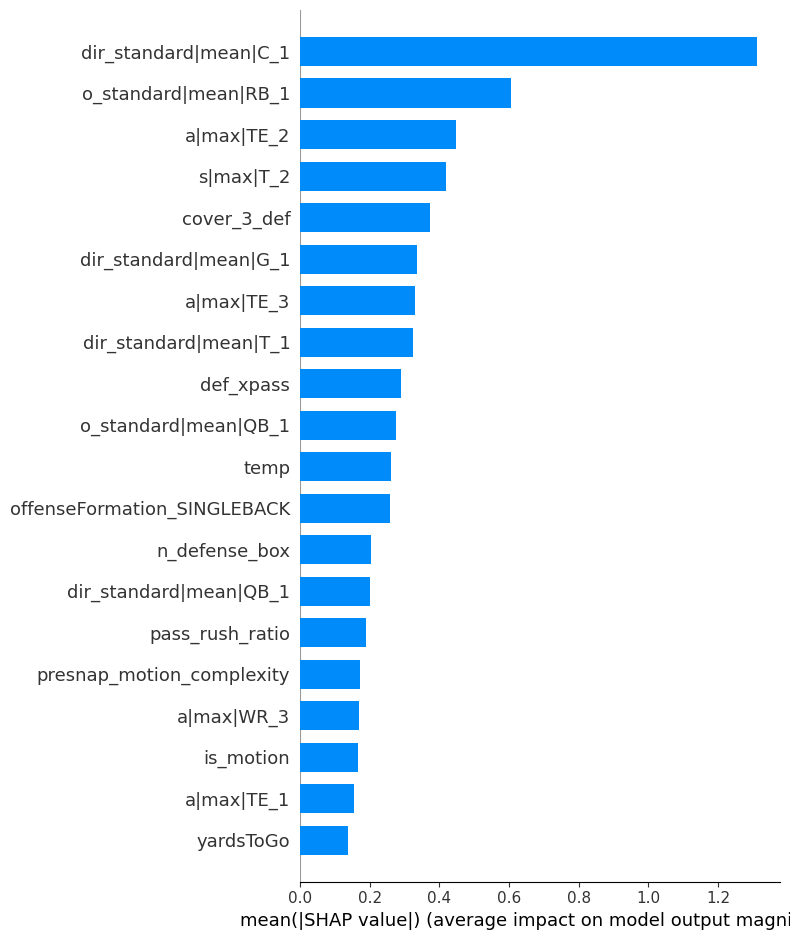

In [19]:
import shap
model = CatBoostClassifier( 
    verbose=False).fit(pool)
shap_values = model.get_feature_importance(Pool(X, label=y, cat_features=cat_features_index),type="ShapValues")
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X, plot_type="bar")

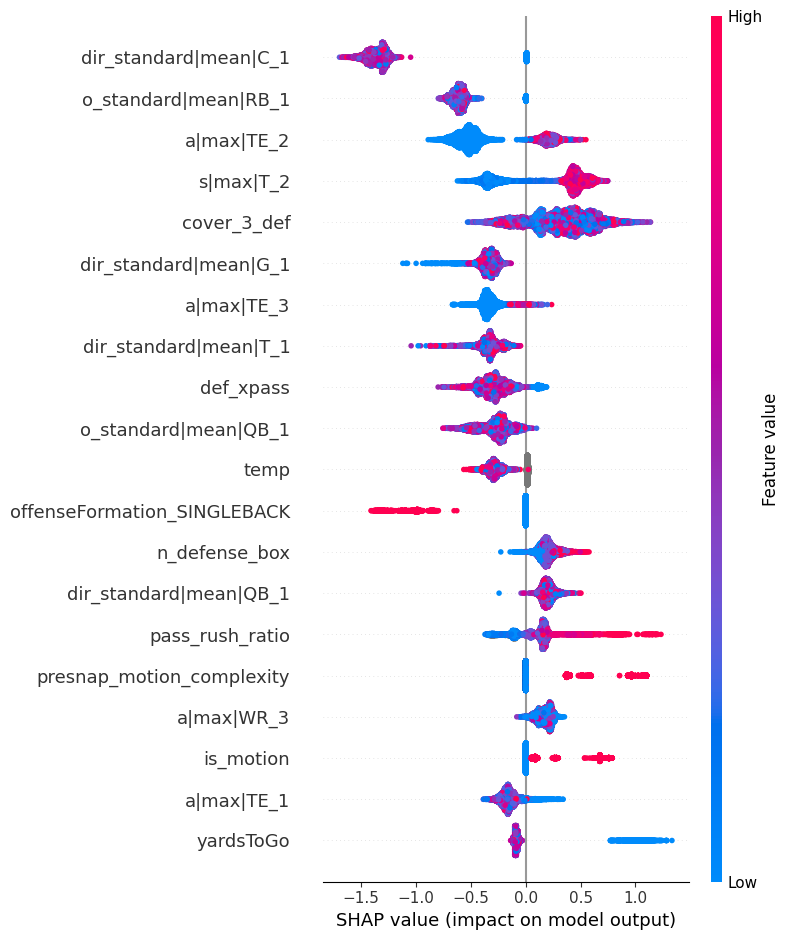

In [20]:
shap.summary_plot(shap_values, X)

In [21]:
final_numeric_columns, final_cat_columns = mark_columns(df=train_data,features=final_features, nc=numeric_columns,cc = cat_columns)

In [22]:
from sklearn.compose import ColumnTransformer
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, final_numeric_columns),
        ('scaler', MinMaxScaler(), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [ ]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
X=train_data[final_features]

y=train_data['pass']
# Define the helper function so that it can be reused

#cat_params = optuna_call(transformer,X,y,SKF,n_trials=20)

[I 2024-10-30 19:37:18,296] A new study created in memory with name: no-name-4e9a7819-8077-4283-8a62-f974e865a56f


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-10-30 19:37:35,595] Trial 0 finished with value: 0.7903269051456959 and parameters: {'learning_rate': 0.061486771166212685, 'depth': 7, 'subsample': 0.2650707060129837, 'colsample_bylevel': 0.4868638923456626, 'iterations': 285}. Best is trial 0 with value: 0.7903269051456959.
[I 2024-10-30 19:38:12,739] Trial 1 finished with value: 0.791494581938158 and parameters: {'learning_rate': 0.09468239198369502, 'depth': 8, 'subsample': 0.750853380775989, 'colsample_bylevel': 0.44974934195065297, 'iterations': 400}. Best is trial 1 with value: 0.791494581938158.
[I 2024-10-30 19:38:50,881] Trial 2 finished with value: 0.7928001876172608 and parameters: {'learning_rate': 0.05929873148445418, 'depth': 8, 'subsample': 0.8280882971874886, 'colsample_bylevel': 0.46553196232488187, 'iterations': 411}. Best is trial 2 with value: 0.7928001876172608.
[I 2024-10-30 19:39:04,738] Trial 3 finished with value: 0.7918382008750438 and parameters: {'learning_rate': 0.060243931157576994, 'depth': 7, '

In [24]:
cat_params= {'learning_rate': 0.08047248508279288, 'depth': 6, 'subsample': 0.6327805587079891, 'colsample_bylevel': 0.6601989777908728, 'iterations': 467}

Training Folds: 100%|██████████| 5/5 [00:22<00:00,  4.40s/it]

Mean Train AUC --> 0.9057
Mean Validation AUC ---> 0.7847
Mean Train Accuracy --> 0.9129
Mean Validation Accuracy ---> 0.7987


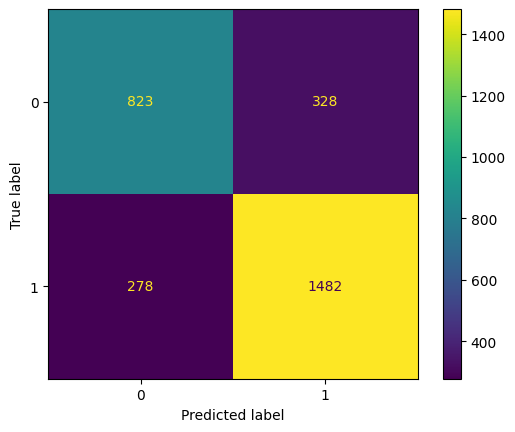

In [25]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  **cat_params, verbose=False))], verbose = True)
TrainML(pipeline,X, y,n_splits,SEED)

In [27]:
from catboost import CatBoost
transformer_impute = build_transformer(imputer,numeric_columns,kind='imputer')
transformer_scale = build_transformer(imputer,numeric_columns,kind='scaler')

X=train_data[final_features]

y=train_data['pass']
numeric_columns=[]
is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat and 'presnap_momentum' not in feature and  'presnap_motion_complexity' not in feature:
        X[feature].fillna(0, inplace=True)
        X[feature].replace([np.inf, -np.inf], 0, inplace=True)
    else:
        numeric_columns.append(feature)

X_transform=transformer_impute.fit_transform(X)

X_transform = pd.DataFrame(X_transform, columns=final_features)

X_transform=transformer_scale.fit_transform(X_transform)

X_transform = pd.DataFrame(X_transform, columns=final_features)

for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X_transform[feature].fillna(0, inplace=True)
        X_transform[feature].replace([np.inf, -np.inf], 0, inplace=True)
        X_transform[feature]=X_transform[feature].astype(int)

cat_features_index = np.where(is_cat)[0]
pool = Pool(X_transform, y, cat_features=cat_features_index, feature_names=list(X_transform.columns))




model = CatBoostClassifier( **cat_params, verbose=False).fit(pool)



In [28]:
from catboost import Pool, cv
cv_dataset = Pool(data=X_transform,
                  label=y,
                  cat_features=cat_features_index)

params = {"iterations": 467,
          "depth": 6,
          "learning_rate":     0.08047248508279288,
          "subsample":  0.6327805587079891,
            "colsample_bylevel":  0.6601989777908728,
          "loss_function": "Logloss",
          "eval_metric":'Accuracy',
          "verbose": False}

scores = cv(cv_dataset,
            params,
            fold_count=5,
            
            plot="True")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7826236264
bestIteration = 406

Training on fold [1/5]

bestTest = 0.7990381312
bestIteration = 243

Training on fold [2/5]

bestTest = 0.7777396084
bestIteration = 445

Training on fold [3/5]

bestTest = 0.8041909997
bestIteration = 383

Training on fold [4/5]

bestTest = 0.8024733768
bestIteration = 456



0.7909459335751847


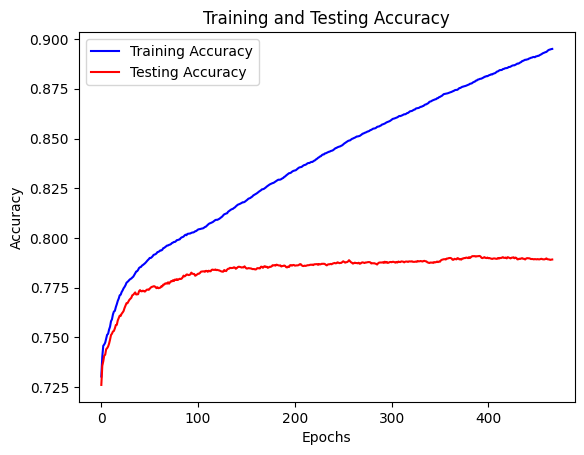

In [29]:
scores
# Plot the accuracy curves
plt.plot(scores['iterations'], scores['train-Accuracy-mean'], 'b', label='Training Accuracy')
plt.plot(scores['iterations'], scores['test-Accuracy-mean'], 'r', label='Testing Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

# Display the pl
print(scores['test-Accuracy-mean'].max())

AUC --> 0.8131690889755406
Accuracy --> 0.8248366013071895


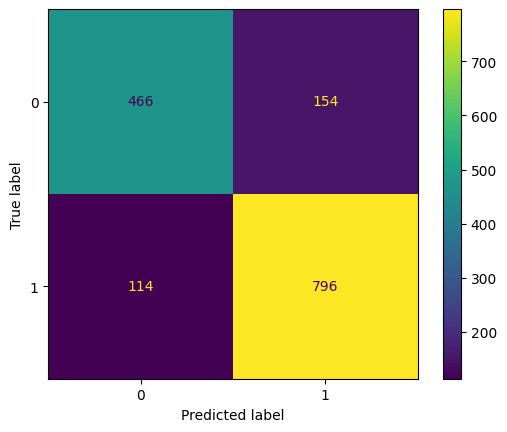

In [30]:
test_ML(test_data, model,final_features,transformer_impute,transformer_scale)